<a href="https://colab.research.google.com/github/TaigoKuriyama/national_park_prediction/blob/master/notebook/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms rtm rdseed adx smap xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: Genuin

In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import math
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
# tsv to Dataframe
df_train = pd.read_csv('train.tsv',sep='\t')
df_test = pd.read_csv('test.tsv',sep='\t')

In [0]:
# Feature engineering from datetime
# https://adtech.cyberagent.io/techblog/archives/259
# https://note.nkmk.me/python-pandas-datetime-timestamp/
def create_date_future(df):
    df['datetime'] = pd.to_datetime(df['datetime']) # dtypeをdatetime64に変換
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek  

In [4]:
create_date_future(df_train)
create_date_future(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3
2,2015-01-01,日光国立公園,29714,2015,1,1,3
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3


In [0]:
# label encoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer

def onehot_encdr_park(df):
    le = preprocessing.LabelEncoder()
    le.fit(df['park'])
    le.transform(['阿寒摩周国立公園', '十和田八幡平国立公園', '日光国立公園', '伊勢志摩国立公園','大山隠岐国立公園','阿蘇くじゅう国立公園', '霧島錦江湾国立公園', '慶良間諸島国立公園']) 
    
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['park'])
    df_park = pd.DataFrame(park_onehot,columns=le.classes_)
    df = pd.concat([df,df_park],axis=1)
    return df

In [6]:
df_train = onehot_encdr_park(df_train)
df_test = onehot_encdr_park(df_test)
df_train.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,霧島錦江湾国立公園
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,0,0,1,0,0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,0,0,0,0,0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,0,1,0,0,0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,0,0,0,0,0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,0,0,0,0,0


In [0]:
def onehot_encdr_dayofweek(df):
    # onehot vector for park column
    encoder = LabelBinarizer()
    park_onehot = encoder.fit_transform(df['dayofweek'])
    df_park = pd.DataFrame(park_onehot,columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
    df = pd.concat([df,df_park],axis=1)
    return df
df_train = onehot_encdr_dayofweek(df_train)
df_test = onehot_encdr_dayofweek(df_test)
df_train.head()}

In [9]:
# show upload dialog
from google.colab import files
uploaded = files.upload()

# データから特徴量作成

In [0]:
# holiday data include Saturday, Sunday
df_holiday = pd.read_csv('holiday.csv')
df_holiday['datetime'] = pd.to_datetime(df_holiday['datetime'])

In [14]:
# holiday data exclude Saturday, Sunday
df_holiday_exc_wkend = pd.read_csv('holiday.csv')
df_holiday_exc_wkend['datetime'] = pd.to_datetime(df_holiday_exc_wkend['datetime'])
df_holiday_exc_wkend['dayofweek'] = df_holiday_exc_wkend['datetime'].dt.dayofweek

# dayofweekが5 or 6(土曜or日曜)の場合、holidayカラムの値を0にする
df_holiday_exc_wkend.loc[(df_holiday_exc_wkend['dayofweek'] == 5) | (df_holiday_exc_wkend['dayofweek'] == 6), 'holiday'] = 0
df_holiday_exc_wkend = df_holiday_exc_wkend[['datetime','holiday']]
df_holiday_exc_wkend = df_holiday_exc_wkend.rename(columns={'holiday': 'pub_holiday'})
df_holiday_exc_wkend.head()

,datetime,pub_holiday
0,2015-01-01,1
1,2015-01-02,0
2,2015-01-03,0
3,2015-01-04,0
4,2015-01-05,0


In [20]:
# 防災科学技術研究所 ⼤⼭鏡ヶ成積雪気象観測施設における積雪気象観測データ
# 日ごとの積雪量の平均データを作成
df_nied_oyama = pd.read_csv('nied_oyama.tsv',sep='\t')
df_nied_oyama['日時'] = pd.to_datetime(df_nied_oyama['日時'])
df_nied_oyama['日時'] = df_nied_oyama['日時'].dt.strftime('%Y-%m-%d')
df_nied_oyama_mean = df_nied_oyama.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]
df_oyama = df_nied_oyama_mean.assign(大山隠岐国立公園=1)
df_oyama = df_oyama.rename(columns={'日時': 'datetime'})
df_oyama.head()

FileNotFoundError: ignored

In [70]:
# sin cos curve
N = 365 # データ数
N_ = 366
n = np.arange(365)
n_ = np.arange(366)

#  Not leap year
sin_cur_not_leap= np.sin(2*np.pi*n/N)
cos_cur_not_leap= np.cos(2*np.pi*n/N)
tan_cur_not_leap= np.tan(2*np.pi*n/N)


#  leap year
sin_cur_leap= np.sin(2*np.pi*n_/N_)
cos_cur_leap= np.cos(2*np.pi*n_/N_)
tan_cur_leap= np.tan(2*np.pi*n_/N_)

# concat for 2015, 2016
sin_cur = np.concatenate((sin_cur_not_leap, sin_cur_leap), axis=0)
cos_cur = np.concatenate((cos_cur_not_leap, cos_cur_leap), axis=0)
tan_cur = np.concatenate((tan_cur_not_leap, tan_cur_leap), axis=0)

# to dataframe
sin_columns = 'sin'
df_sin_cur_train = pd.DataFrame(data=sin_cur,dtype='float')
df_cos_cur_train = pd.DataFrame(data=cos_cur,dtype='float')
df_tan_cur_train = pd.DataFrame(data=tan_cur,dtype='float')


# concat for 2017
df_sin_cur_test = pd.DataFrame(data=sin_cur_not_leap,dtype='float')
df_cos_cur_test = pd.DataFrame(data=cos_cur_not_leap,dtype='float')
df_tan_cur_test = pd.DataFrame(data=tan_cur_not_leap,dtype='float')

,0
0,0.000000
1,0.017216
2,0.034442
3,0.051689
4,0.068966
5,0.086284
6,0.103654
7,0.121086
8,0.138591
9,0.156179


In [12]:
# taget encoding
#　df_train_mean = df_train.groupby('datetime',as_index=False).mean()
df_visitors_mean = df_train.groupby('park',as_index=False).mean()[['park','visitors']]
df_visitors_mean

,park,visitors
0,伊勢志摩国立公園,16314.704514
1,十和田八幡平国立公園,8890.787962
2,大山隠岐国立公園,716.424077
3,慶良間諸島国立公園,137.994528
4,日光国立公園,11324.525308
5,阿寒摩周国立公園,4422.611491
6,阿蘇くじゅう国立公園,270.445964
7,霧島錦江湾国立公園,15416.395349


In [23]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather.head()

FileNotFoundError: ignored

In [24]:
df_weather = pd.read_csv('../data/raw/weather.tsv',sep='\t')
df_weather['日時'] = pd.to_datetime(df_weather['年月日'])
df_weather_mean = df_weather.groupby('日時',as_index=False).mean()[['日時','積雪深(cm)', '気温(℃)']]

FileNotFoundError: ignored

### 作成した特徴量と学習データの結合

In [75]:
# 学習データと休日データの結合
#df_merged = pd.merge(df_train,df_holiday,on='datetime') # 
df_merged = pd.merge(df_train,df_holiday_exc_wkend,on='datetime')
#df_merged =  pd.merge(df_merged,df_holiday_exc_wkend,on='datetime')

# 学習データと⼤⼭気象データの結合
#df_oyama['datetime'] = pd.to_datetime(df_oyama['datetime'])
#df_merged = pd.merge(df_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')

df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [76]:
# 学習データとsin/cosカーブデータの結合
df_datetime_train = df_train[~df_train.duplicated(subset='datetime')]['datetime']
df_datetime_train = df_datetime_train.reset_index()
df_datetime_train = df_datetime_train['datetime']
df_sin_cos_tan = pd.concat([df_datetime_train,df_sin_cur_train,df_cos_cur_train,df_tan_cur_train], axis=1)
df_sin_cos_tan.columns = ['datetime', 'sin', 'cos','tan']
df_merged = pd.merge(df_merged,df_sin_cos,on='datetime')
df_merged.head()

,datetime,park,visitors,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,tan
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
1,2015-01-01,十和田八幡平国立公園,34757,2015,1,1,3,0,1,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
2,2015-01-01,日光国立公園,29714,2015,1,1,3,0,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
3,2015-01-01,伊勢志摩国立公園,42652,2015,1,1,3,1,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
4,2015-01-01,大山隠岐国立公園,3637,2015,1,1,3,0,0,1,...,0,0,1,0,0,0,1,0.0,1.0,0.0


In [27]:
df_merged = pd.merge(df_merged,df_visitors_mean,on='park')
df_merged.head()

,datetime,park,visitors_x,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,visitors_y
0,2015-01-01,阿寒摩周国立公園,11028,2015,1,1,3,0,0,0,...,0,0,1,0,0,0,1,0.000000,1.000000,4422.611491
1,2015-01-02,阿寒摩周国立公園,11153,2015,1,2,4,0,0,0,...,0,0,0,1,0,0,0,0.017213,0.999852,4422.611491
2,2015-01-03,阿寒摩周国立公園,12343,2015,1,3,5,0,0,0,...,0,0,0,0,1,0,0,0.034422,0.999407,4422.611491
3,2015-01-04,阿寒摩周国立公園,6732,2015,1,4,6,0,0,0,...,0,0,0,0,0,1,0,0.051620,0.998667,4422.611491
4,2015-01-05,阿寒摩周国立公園,4877,2015,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0.068802,0.997630,4422.611491


In [98]:
# drop columns which is not needed
df_except_y = df_merged.drop(['year','park','visitors','datetime'], axis=1)
X_train = df_except_y.as_matrix() 
y_train = df_merged['visitors'].as_matrix()
df_except_y.head()

,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,tan
0,1,1,3,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
1,1,1,3,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
2,1,1,3,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
3,1,1,3,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0
4,1,1,3,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0.0,1.0,0.0


### 作成した特徴量とテストデータの結合

In [101]:
# holidayデータとのマージ
#df_test_merged = pd.merge(df_test,df_holiday,on='datetime')
df_test_merged = pd.merge(df_test,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_holiday_exc_wkend,on='datetime')
#df_test_merged = pd.merge(df_test_merged,df_oyama,on=['大山隠岐国立公園','datetime'],how='left')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [102]:
# sin/cos/tanカーブデータとのマージ
df_datetime_test = df_test[~df_test.duplicated(subset='datetime')]['datetime']
df_datetime_test = df_datetime_test.reset_index()
df_datetime_test = df_datetime_test['datetime']
df_sin_cos_test = pd.concat([df_datetime_test,df_sin_cur_test,df_cos_cur_test,df_tan_cur_test], axis=1)
df_sin_cos_test.columns = ['datetime', 'sin', 'cos','tan']
df_test_merged = pd.merge(df_test_merged,df_sin_cos_test,on='datetime')
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,tan
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,1,0,0.0,1.0,0.0


In [49]:
df_test_merged.head()

,index,datetime,park,year,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,...,阿蘇くじゅう国立公園,霧島錦江湾国立公園,Mon,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday
0,0,2017-01-01,阿寒摩周国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,2017-01-01,十和田八幡平国立公園,2017,1,1,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2,2017-01-01,日光国立公園,2017,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,2017-01-01,伊勢志摩国立公園,2017,1,1,6,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,2017-01-01,大山隠岐国立公園,2017,1,1,6,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [100]:
# target encodingとのマージ
df_test_merged = pd.merge(df_test_merged,df_visitors_mean,on='park')
df_test_merged.head()

KeyError: ignored

In [103]:
# drop columns which is not needed
df_test_merged = df_test_merged.drop(['year','park','datetime','index'], axis=1)
df_test_merged = df_test_merged.fillna(0)
X_test = df_test_merged.as_matrix()
df_test_merged.head()

,month,day,dayofweek,伊勢志摩国立公園,十和田八幡平国立公園,大山隠岐国立公園,慶良間諸島国立公園,日光国立公園,阿寒摩周国立公園,阿蘇くじゅう国立公園,...,Tue,Wed,Thu,Fri,Sat,Sun,pub_holiday,sin,cos,tan
0,1,1,6,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
1,1,1,6,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
2,1,1,6,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
3,1,1,6,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0
4,1,1,6,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0.0,1.0,0.0


 ## Neural Network

In [118]:
# Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

model = KerasRegressor(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD','Adam']
batch_size = [10, 30, 50]
epochs = [10, 50, 100]
param_grid = dict(optimizer=optimizer, batch_size=batch_size, epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(X_train_cv, y_train_cv)

# predict
y_test_pred_dl = reg_dl.predict(X_test_cv)
y_train_pred_dl = reg_dl.predict(X_train_cv)

KeyboardInterrupt: ignored

In [119]:
# SVR
from sklearn.svm import SVR

reg_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

# training
reg_svr.fit(X_train_cv, y_train_cv)

# predict
y_test_pred_svr= reg_svr.predict(X_test_cv)
y_train_pred_svr = reg_svr.predict(X_train_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_test_pred_svr)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_train_pred_svr)))

MAE train：6640.256832070605
MAE test：7096.477508449476


In [0]:
# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_test_pred_dl)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_train_pred_dl)))

## xgboost

In [0]:
import math
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [0]:
# parametar tuning
params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         "colsample_bytree": [0.5,1.0],
         }

In [0]:
model = xgb.XGBRegressor()
cv = GridSearchCV(model,params,cv=10,n_jobs=-1)

In [0]:
# cross validation
from sklearn.model_selection import train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train,test_size=0.5,random_state=0,shuffle=False)

In [108]:
# model
cv.fit(X_train_cv, y_train_cv)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [109]:
# predict
y_test_pred = cv.predict(X_test_cv)
y_train_pred = cv.predict(X_train_cv)

# 評価
from sklearn.metrics import mean_absolute_error
print('MAE train：{0}'.format(mean_absolute_error(y_train_cv, y_train_pred)))
print('MAE test：{0}'.format(mean_absolute_error(y_test_cv, y_test_pred)))

MAE train：2045.7497492293164
MAE test：2843.218553122352


### sin cos追加
MAE test：1630.9984953020241  
MAE train：903.9336502896668  
提出結果：1815.2318495033333

### sin cos tan
MAE train：1179.305741077898  
MAE test：2629.263019825626  
提出結果：1,745.20888

### sin cos tan, year削除
MAE train：1179.305741077898  
MAE test：2629.263019825626  
提出結果：1,729.58493

### sin cos追加、曜日のone hotを削除
MAE train：1179.305741077898  
MAE test：2629.263019825626  
提出結果：1887.2631403236114  

### sin cos追加、ターゲットエンコーディングを追加
MAE train：230.22719528671817  
MAE test：3480.3254402260286  
提出結果： 6635



### 誤差分析
Residuals：残差(誤差の推定量)

In [1]:
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train_cv, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test_cv, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.scatter(y_train_pred, y_train_cv, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_test_pred, y_test_cv, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')


plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10000, 100000])
plt.show()

NameError: ignored

In [111]:
# model
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [2, 3, 5, 10], 'subsample': [0.5, 0.8, 0.9, 1], 'colsample_bytree': [0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [112]:
# model
reg = xgb.XGBRegressor(**cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
# 学習モデルの保存、読み込み
import pickle
#pickle.dump(reg, open("../model/model_8.pkl", "wb"))
#reg = pickle.load(open("../model/model_8.pkl", "rb"))

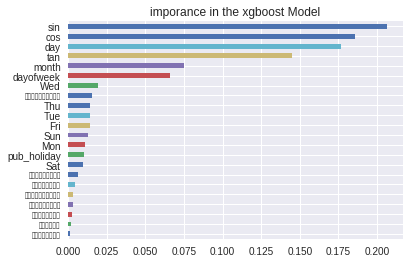

In [113]:
# future importance
import pandas as pd
import matplotlib.pyplot as plt
importances = pd.Series(reg.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

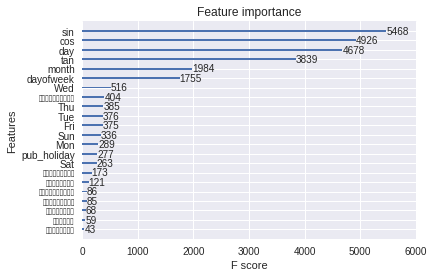

In [114]:
features =df_except_y.columns[df_except_y.any()]
mapper = {'f{0}'.format(i): v for i, v in enumerate(features)}
mapped = {mapper[k]: v for k, v in reg._Booster.get_fscore().items()}
xgb.plot_importance(mapped)

In [0]:
# predict
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [0]:
# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_test_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit =df_submit.where(df_submit.iloc[:, [0]] > 0, 0)

In [0]:
df_submit.to_csv('submit_17.tsv',sep='\t',header=None)
files.download('submit_17.tsv')

In [128]:
# second feature matrix
X_train2 = pd.DataFrame( {'XGB': reg.predict(X_train),
     'SVR': reg_svr.predict(X_train),
    })
X_train2.tail()

ValueError: ignored

AttributeError: ignored

In [129]:
# second-feature modeling using linear regression
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
# prediction using the test set
X_test2 = pd.DataFrame( {'XGB': reg.predict(X_test),
     'SVR': reg_svr.predict(X_test)
    })

# Don't forget to convert the prediction back to non-log scale
y_pred = np.exp(reg.predict(X_test2))

submission.to_csv('houseprice.csv', index=False)

# create submit file
df_submit = pd.DataFrame({
    '':df_test['index'],
    '':y_pred})
# pandas.[DataFrame or Series].where(cond,other=xxx) condがFalseの時にotherを代入
# マイナスと予測した結果を０に修正
df_submit =df_submit.where(df_submit.iloc[:, [0]] > 0, 0)

ValueError: ignored